# Surrogate Modeling Regression Example
This example illustrates the difference between Kriging and the (Batch) XGBoost algorithm. 
The aim is to show the difference between Kriging and XGBoost on the exact same examples in
the standard setting of regression. We do not expect a great difference in performance.
Note that there is no iterative training in this example. 

## Setup the Environment
Note that this code has only been tested on Python 3

In [19]:
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [27]:
from functions import *
%matplotlib inline
import seaborn

### Initialize the parameters and constants

In [28]:
# Set the ABM Evaluation Budget
budget = 500

# Set out-of-sample test and montecarlo sizes
test_size = 100
montecarlos = 100

# Get an on out-of-sample test set that does not have combinations from the
# batch or iterative experiments
final_test_size = (test_size * montecarlos)

# Set the ABM parameters and support
islands_exploration_range = np.array([
    (0.0, 10),  # rho
    (0.8, 2.0),  # alpha
    (0.0, 1.0),  # phi
    (0.0, 1.0),  # pi
    (0.0, 1.0)])  # eps

param_dims = islands_exploration_range.shape[0]

## Evaluate the entire Budget in Batch and Generate unique out-of-sample test set
Draw these samples according to a pseudo-random, well spaced generator. Here we use Sobol sequences because of their known coverage and compute performance. Note that the out of sample set is taken uniformly at random from the support. If you take points that are structured by the sobol sequence generator, then the performance evaluation will not be blind and will actually bias the Sobol structure. The aim of the out of sample set is to demonstrate out of sample points that can come from any point in the support of the parameters.

In [29]:
load_data = True

if load_data: # This is only for the budget = 500 setting
    evaluated_set_X_batch = pd.read_csv('X.csv',index_col=0).values
    evaluated_set_y_batch = pd.read_csv('y.csv',index_col=0).values
    oos_set = pd.read_csv('X_oos.csv',index_col=0).values
    y_test = pd.read_csv('y_oos.csv',index_col=0).values
else:
    # Generate Sobol samples for training set
    n_dimensions = islands_exploration_range.shape[0]
    evaluated_set_X_batch = get_sobol_samples(n_dimensions, budget, islands_exploration_range)
    evaluated_set_y_batch = evaluate_islands_on_set(evaluated_set_X_batch)
    
    pd.DataFrame(evaluated_set_X_batch).to_csv("X.csv")
    pd.DataFrame(evaluated_set_y_batch).to_csv("y.csv")
    
    # Build Out-of-sample set
    oos_set = get_unirand_samples(n_dimensions, final_test_size*budget, islands_exploration_range)
    selections = []
    for i, v in enumerate(oos_set):
        if (v not in evaluated_set_X_batch):
            selections.append(i)
    oos_set = unique_rows(oos_set[selections])[:final_test_size]

    # Evaluate the test set for the ABM response
    y_test = evaluate_islands_on_set(oos_set)
    
    pd.DataFrame(oos_set).to_csv("X_oos.csv")
    pd.DataFrame(y_test).to_csv("y_oos.csv")

## Compute the Kriging Surrogate

In [30]:
# We use the default Gaussian Kernel and L-BFGS optimizer.
surrogate_models_kriging = GaussianProcessRegressor(random_state=0)
surrogate_models_kriging.fit(evaluated_set_X_batch, evaluated_set_y_batch)

GaussianProcessRegressor(random_state=0)

## Compute the XGBoost Surrogate

In [31]:
# This surrogate will not have multiple iterations. It will run on the entire budget of evaluations.
surrogate_model_XGBoost = fit_surrogate_model(evaluated_set_X_batch, evaluated_set_y_batch)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8728
Function value obtained: 0.0168
Current minimum: 0.0168
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7562
Function value obtained: 0.0100
Current minimum: 0.0100
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5448
Function value obtained: 0.0140
Current minimum: 0.0100
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3526
Function value obtained: 0.0191
Current minimum: 0.0100
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0299
Function value obtained: 0.0142
Current minimum: 0.0100
Iteration No: 6 started. Evaluating

# Evaluate both surrogates on the test set

In [32]:
y_hat_test = [None] * 2
y_hat_test[0] = surrogate_models_kriging.predict(oos_set)
y_hat_test[1] = surrogate_model_XGBoost.predict(oos_set)

# MSE performance
mse_perf = np.zeros((2, montecarlos))
for sur_idx in range(len(y_hat_test)):
    for i in range(montecarlos):
        mse_perf[sur_idx, i] = mean_squared_error(y_test[i * test_size:(i + 1) * test_size],
                                                  y_hat_test[int(sur_idx)][i * test_size:(i + 1) * test_size])

## Plot the out-of-sample Monte Carlo performance densities for each of the methods

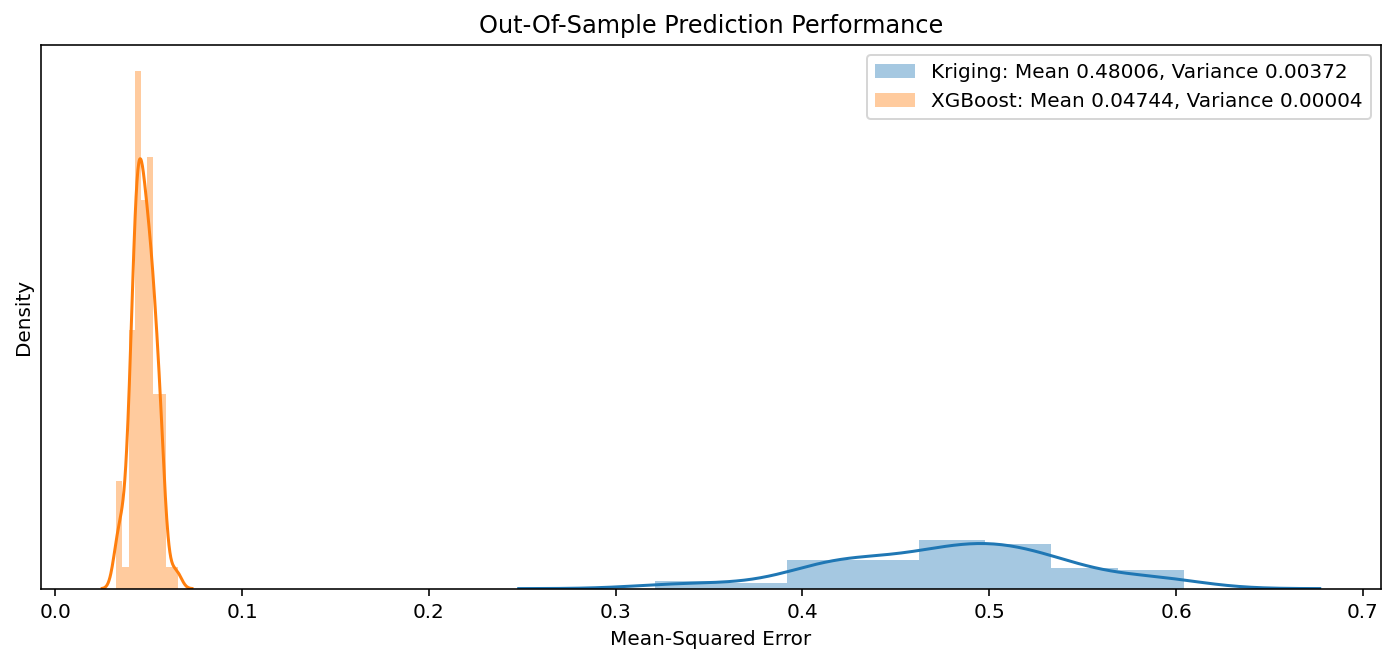

In [33]:
experiment_labels = ["Kriging", "XGBoost (Batch)"]

mse_perf = pd.DataFrame(mse_perf, index=experiment_labels)

k_label = "Kriging: Mean " + '{:2.5f}'.format(mse_perf.iloc[0, :].mean()) + ", Variance " + '{:2.5f}'.format(mse_perf.iloc[0, :].var())
xgb_label = "XGBoost: Mean " + '{:2.5f}'.format(mse_perf.iloc[1, :].mean()) + ", Variance " + '{:2.5f}'.format(mse_perf.iloc[1, :].var())

fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(mse_perf.iloc[0, :], label=k_label, ax=ax)
sns.distplot(mse_perf.iloc[1, :], label=xgb_label, ax=ax)

plt.title("Out-Of-Sample Prediction Performance")
plt.xlabel('Mean-Squared Error')
plt.yticks([])

plt.legend()

fig.savefig("xgboost_kriging_ba_comparison_" + str(budget) + ".png");